#Lab.15 / IBM3202 – Protein Structure Prediction using ColabFold followed by Molecular Dynamics on GROMACS

### Overview

In this hands-on tutorial, we will first employ **ColabFold**, developed by Milot Mirdita, Sergey Ovchinnikov and Martin Steinegger to predict the structure of a given protein on **Google Colab**. ColabFold is, in short, an implementation of **AlphaFold2** using **MMseqs2** and **HHsearch**, enabling ultra fast search and cluster huge protein and nucleotide sequence sets, which is key for accelerating the generation of the multiple sequence alignment (**MSA**) for protein structure prediction using AlphaFold2 on Google Colab. We highly recommend that you check out the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read their manuscript for more information:
[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1) 

Once the protein structure is predicted, we will install **GROMACS**, an MD simulation package, which we will use to set-up and perform MD simulations on our predicted protein. We will visualize our protein structure using **py3Dmol**, while the simulation trajectories from our MD production runs will be visualized in a web version of **NGLview**. For more detailed information on other analysis of the motions of our protein, we highly recommend to check the [GROMACS tutorials](http://www.mdtutorials.com/gmx/) developed by Justin Lemkul and our implementation of some of these analyses on Google Colab in our [Molecular Modeling and Simulation GitHub](https://github.com/pb3lab/ibm3202), as well as our article:
[Engelberger F, Galaz-Davison P, Bravo G, Rivera M, Ramirez-Sarmiento CA. Developing and Implementing Cloud-Based Tutorials That Combine Bioinformatics Software, Interactive Coding, and Visualization Exercises for Distance Learning on Structural Bioinformatics. *J Chem Educ*, 2021](https://pubs.acs.org/doi/full/10.1021/acs.jchemed.1c00022)


## Part 1. Protein Structure Prediction on ColabFold

We will run Colab on a readily defined sequence using the default parameters (except for the recycling, which is now set to 1). Therefore, the instructions for this tutorial are:

1. Paste your protein sequence in the input field.
2. Run ColabFold by clicking on the "Play" button on the left of each cell.
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

Once the final protein structure is predicted, the results will be visually presented on ColabFold and a ZIP file will be generated, which contains the following information:

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

For the description of additional options (prediction of protein complexes, custom MSAs, custom templates, etc) please check out the latest version of [ColabFold](http://colabfold.com).


In [1]:
#@title 1. Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'test' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
use_amber = False #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False


In [2]:
#@markdown ### 2. MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [3]:
#@markdown ### 3. Advanced settings
model_type = "auto" #@param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
#@markdown - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
num_recycles = 1 #@param [1,3,6,12,24,48] {type:"raw"}
save_to_google_drive = False #@param {type:"boolean"}

#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.


if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [4]:
#@title 4. Install AF2 dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

2022-08-05 13:59:21,740 Found 5 citations for tools or databases
2022-08-05 13:59:30,688 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


2022-08-05 13:59:32,147 Running model_1
2022-08-05 14:00:19,745 model_1 took 42.7s (1 recycles) with pLDDT 96.3 and ptmscore 0.758


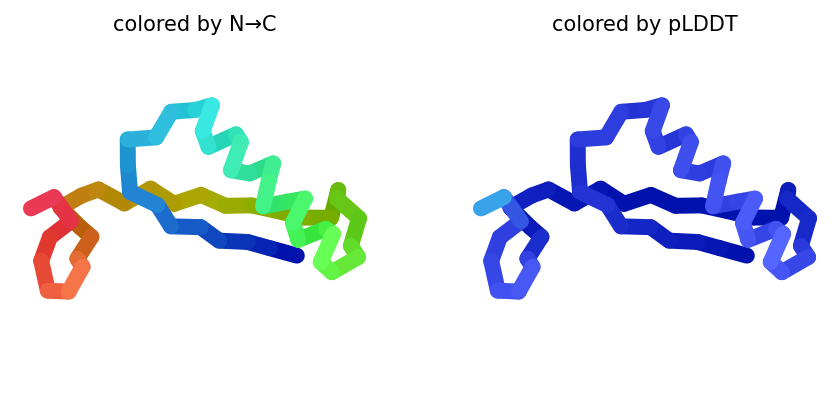

2022-08-05 14:00:25,778 Running model_2
2022-08-05 14:00:35,320 model_2 took 7.8s (1 recycles) with pLDDT 96.9 and ptmscore 0.767


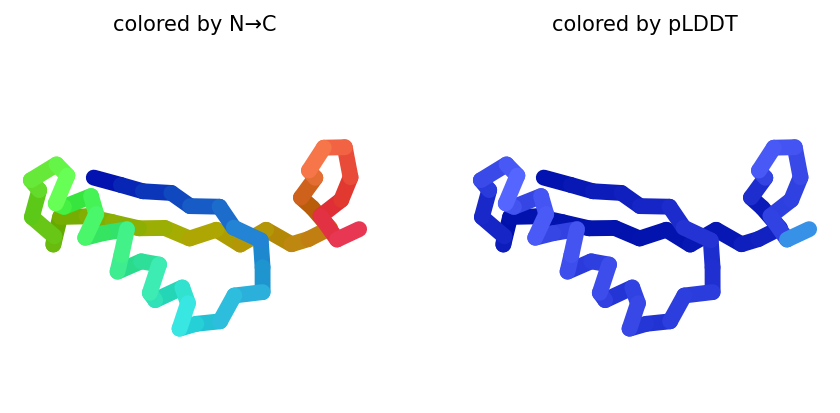

2022-08-05 14:00:40,591 Running model_3
2022-08-05 14:00:50,100 model_3 took 7.9s (1 recycles) with pLDDT 97.5 and ptmscore 0.782


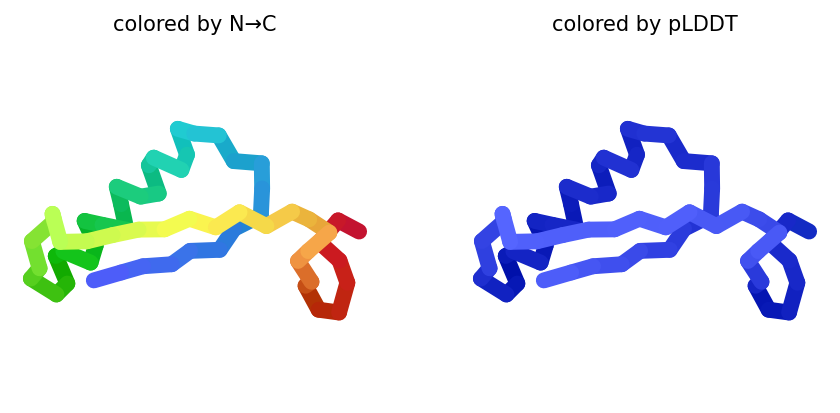

2022-08-05 14:00:55,322 Running model_4
2022-08-05 14:01:04,981 model_4 took 8.0s (1 recycles) with pLDDT 97.1 and ptmscore 0.776


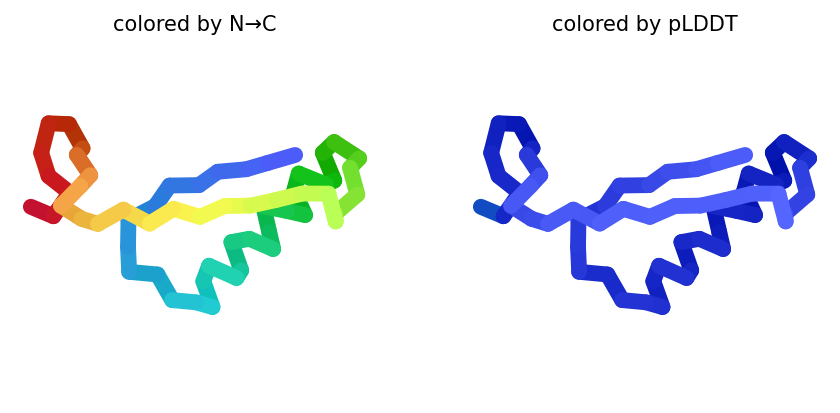

2022-08-05 14:01:10,544 Running model_5
2022-08-05 14:01:20,203 model_5 took 8.0s (1 recycles) with pLDDT 96.8 and ptmscore 0.781


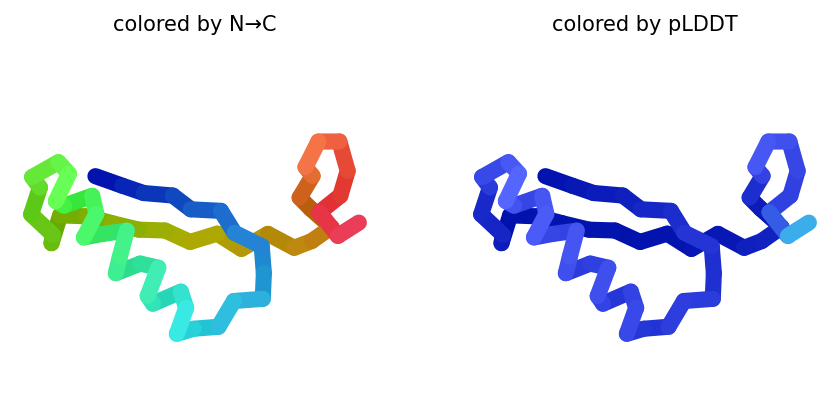

2022-08-05 14:01:25,482 reranking models by plddt
2022-08-05 14:01:27,055 Done


In [5]:
#@title 5. Run Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=150)
  plt.show()
  plt.close()

result_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi
)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

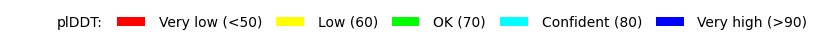

In [6]:
#@title 6. Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 


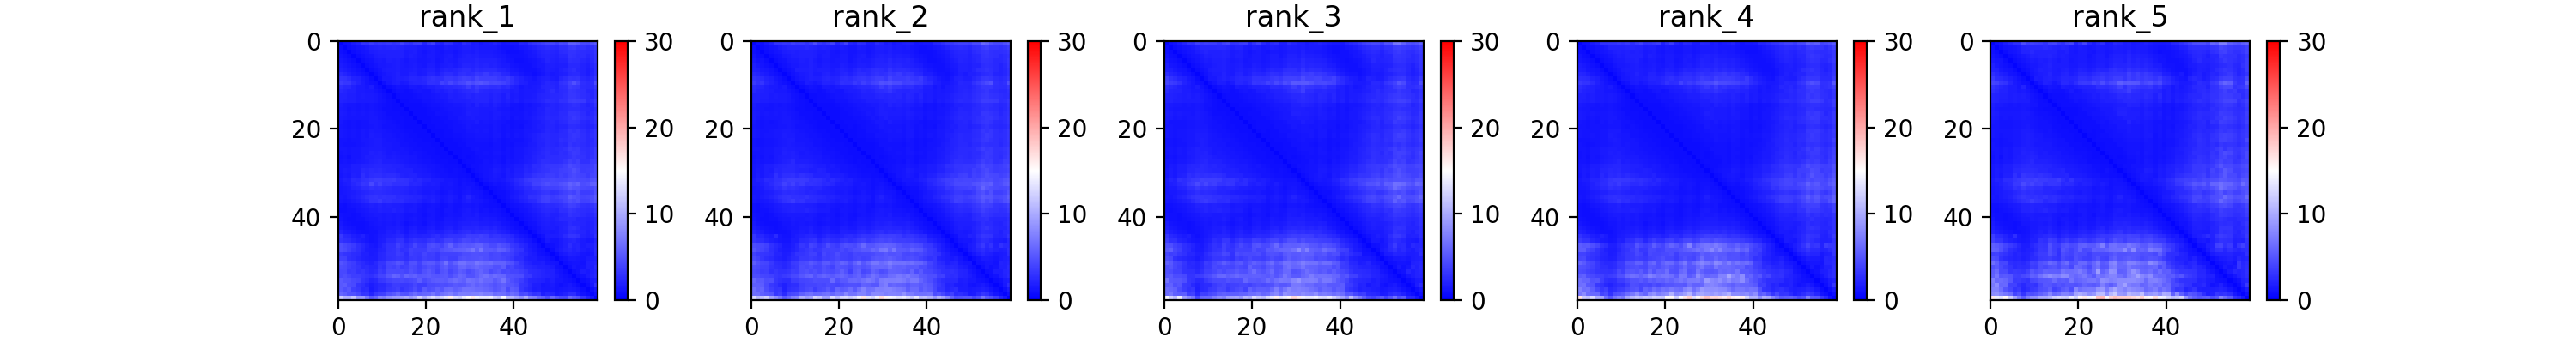
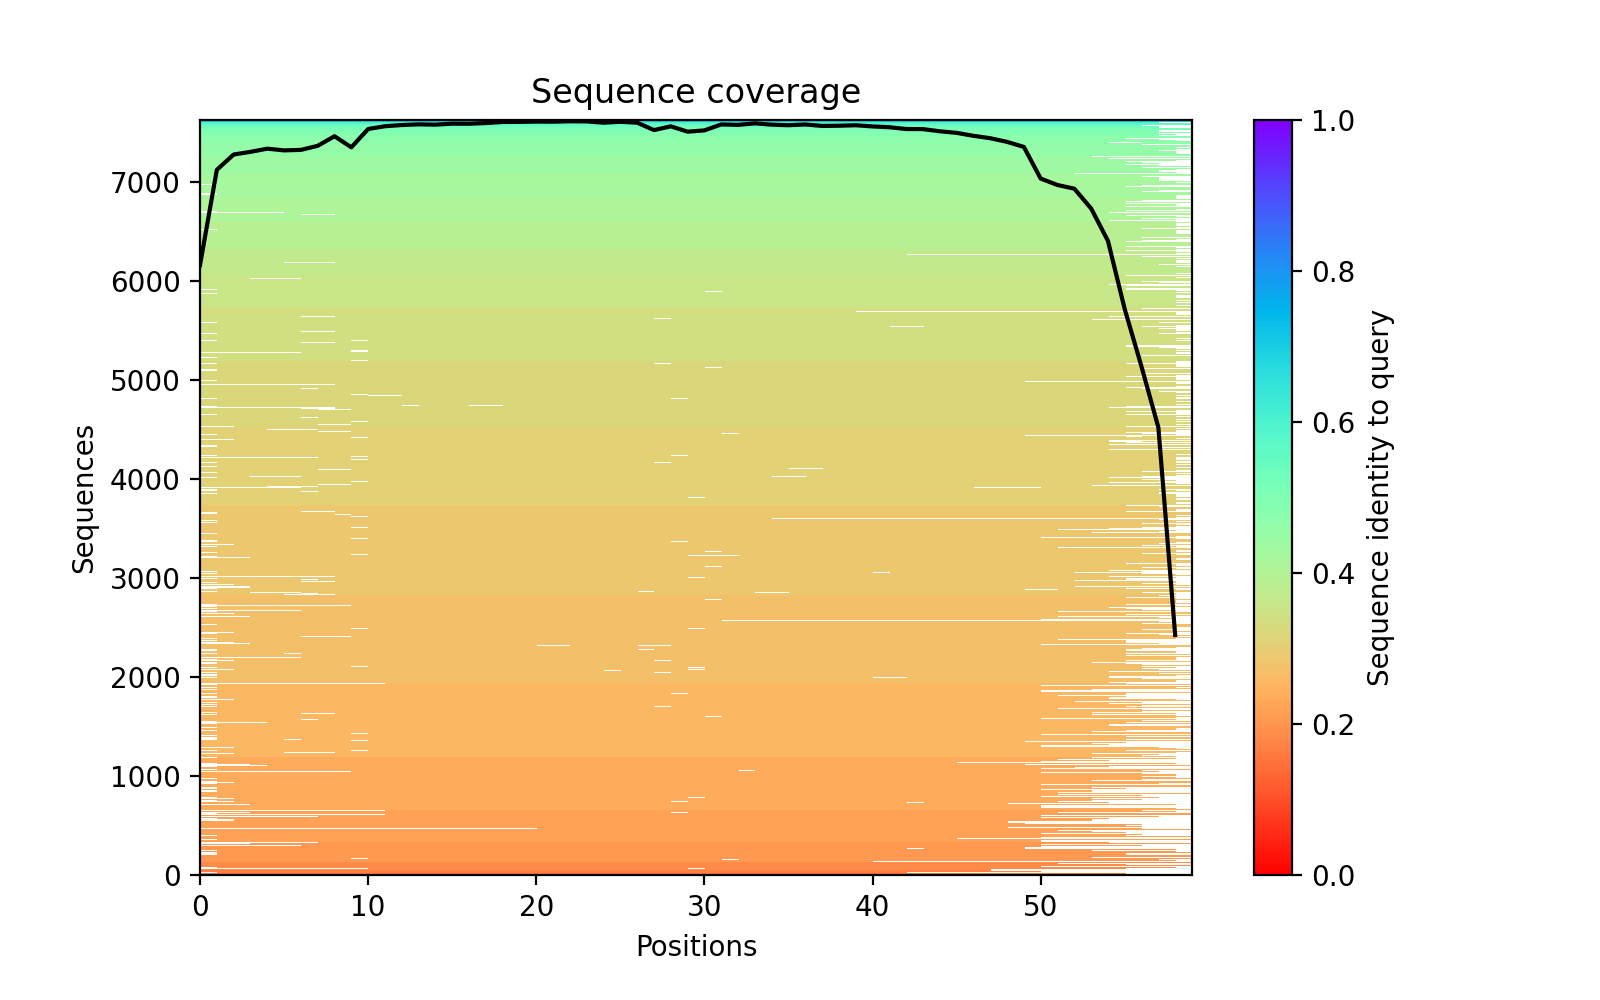
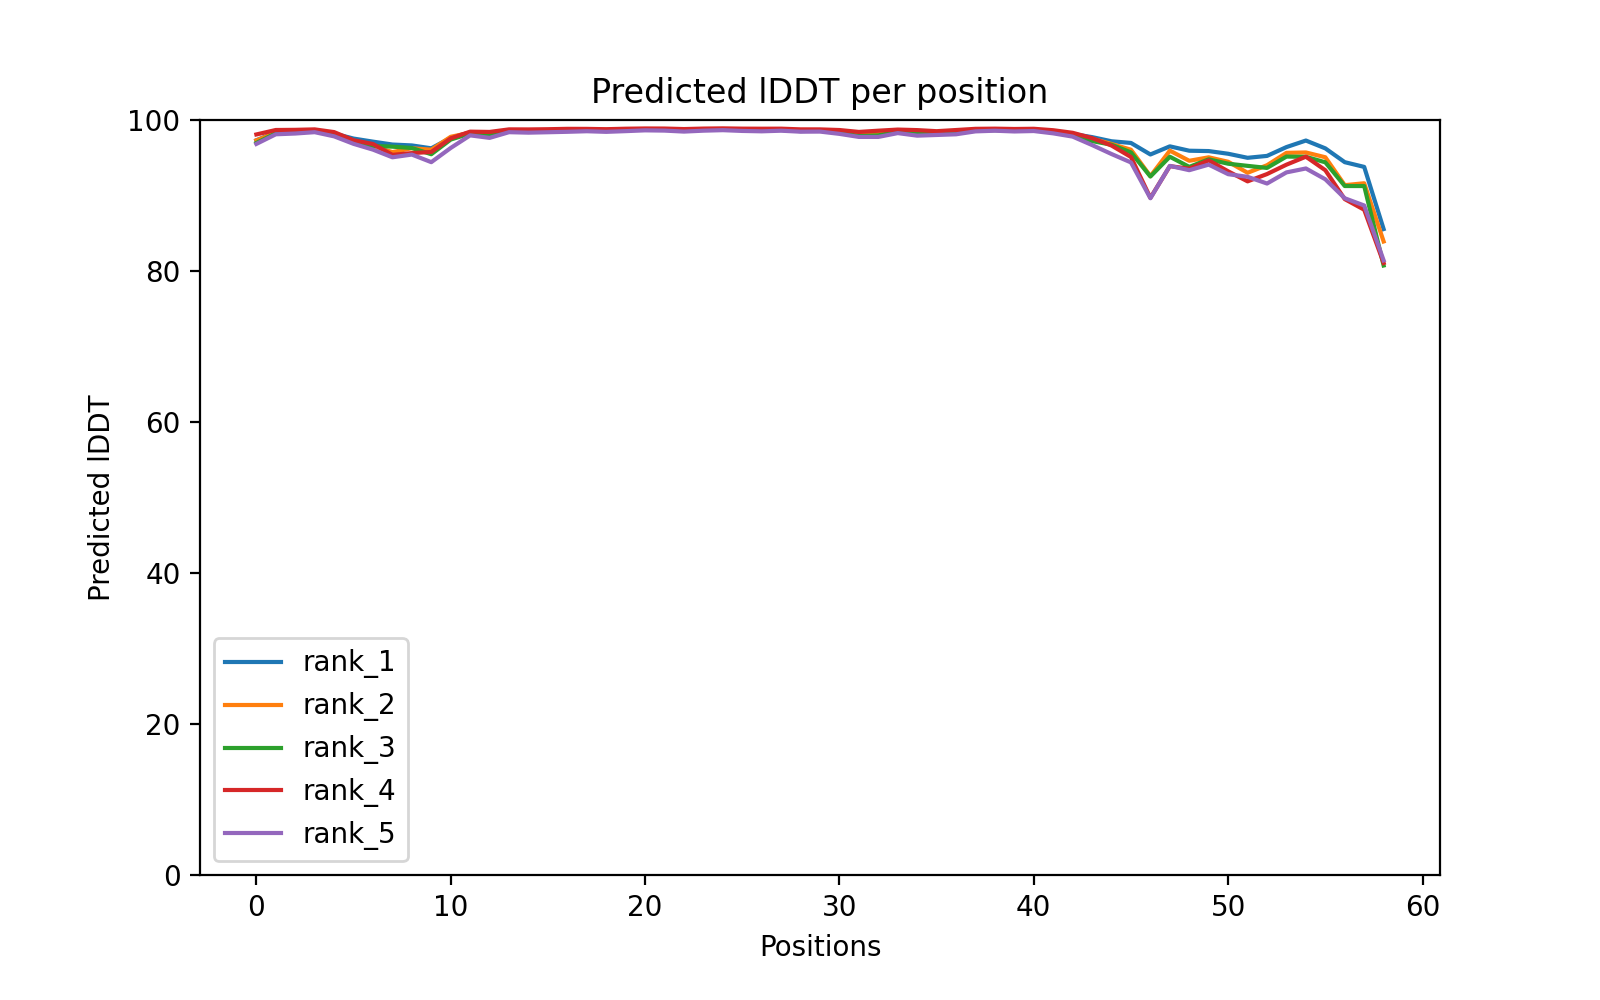

In [7]:
#@title 7. Generate plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


### Description of the plots
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - Model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

In [8]:
#@title 8. Package and download results (optional)
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

  adding: config.json (deflated 49%)
  adding: test_a5e17_predicted_aligned_error_v1.json (deflated 89%)
  adding: test_a5e17_unrelaxed_rank_1_model_3_scores.json (deflated 72%)
  adding: test_a5e17_unrelaxed_rank_2_model_4_scores.json (deflated 72%)
  adding: test_a5e17_unrelaxed_rank_3_model_2_scores.json (deflated 72%)
  adding: test_a5e17_unrelaxed_rank_4_model_5_scores.json (deflated 72%)
  adding: test_a5e17_unrelaxed_rank_5_model_1_scores.json (deflated 71%)
  adding: test_a5e17.a3m (deflated 60%)
  adding: test_a5e17_unrelaxed_rank_1_model_3.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_rank_2_model_4.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_rank_3_model_2.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_rank_4_model_5.pdb (deflated 78%)
  adding: test_a5e17_unrelaxed_rank_5_model_1.pdb (deflated 78%)
  adding: cite.bibtex (deflated 52%)
  adding: test_a5e17_coverage.png (deflated 12%)
  adding: test_a5e17_PAE.png (deflated 15%)
  adding: test_a5e17_plddt.png (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 2. Download and install GROMACS

We will first start by setting up **GROMACS** on Google Colab, based on a  previously compiled and installed GROMACS.


In [9]:
#@title ### Installing GROMACS 2020.6 version
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
!tar xzf gromacs.tar.gz
# It is recommended (and required for GROMACS 2021) to upgrade cmake
!pip install cmake --upgrade

--2022-08-05 14:01:27--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35608971 (34M) [application/octet-stream]
Saving to: ‘gromacs.tar.gz’

gromacs.tar.gz      100%[===================>]  33.96M  --.-KB/s    in 0.1s    

2022-08-05 14:01:30 (334 MB/s) - ‘gromacs.tar.gz’ saved [35608971/35608971]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.9 MB 1.3 MB/s 
  Attempting uninstall: cmake
    Found existing installation: cmake 3.22.6
    Uninstalling cmake-3.22.6:
      Successfully uninstalled cmake-3.22.6


In [10]:
#@title ### Checking that GROMACS 2020.6 runs on Google Colab

%%bash
source /content/gromacs/bin/GMXRC
gmx -h

SYNOPSIS

gmx [-[no]h] [-[no]quiet] [-[no]version] [-[no]copyright] [-nice <int>]
    [-[no]backup]

OPTIONS

Other options:

 -[no]h                     (no)
           Print help and quit
 -[no]quiet                 (no)
           Do not print common startup info or quotes
 -[no]version               (no)
           Print extended version information and quit
 -[no]copyright             (yes)
           Print copyright information on startup
 -nice   <int>              (19)
           Set the nicelevel (default depends on command)
 -[no]backup                (yes)
           Write backups if output files exist

Additional help is available on the following topics:
    commands    List of available commands
    selections  Selection syntax and usage
To access the help, use 'gmx help <topic>'.
For help on a command, use 'gmx help <command>'.


                         :-) GROMACS - gmx, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
        M

## Part 3. Preparing our MD simulation system
### Part 3.A. Parameterizing the atoms building up our system for MD simulations

Now, we will work with GROMACS to parameterize our protein, generating:

- A .gro or .pdb coordinate file that contains all the atom types as defined by a given force field (including hydrogens).
- A .top topology file containing the parameters for bonds, angles, dihedrals and non-bonded interactions defined by a given force field (potential energy function) to employ in our simulations.

We will parameterize our protein using the AMBER99SB-ILDN force field on GROMACS and obtain these files using gmx as shown in the code cell below. This force field is extensively used in MD simulations and has parameters that well-represent the dynamics and flexibility of folded proteins. Notice that the dynamics of highly motile proteins or intrinsically disordered regions is not the main dataset for which this force field was parameterized, and other options may better suit such goals.

In [11]:
#@title #### 1. Making a copy of the ColabFold predictions for safety
!mkdir /content/results
!cp /content/test*pdb /content/results/.
!cp /content/test*json /content/results/.
!cp /content/test*png /content/results/.
!cp /content/results/*rank_1*.pdb /content/structure.pdb

In [12]:
#@title #### 2. Parameterizing our protein using the AMBER99SB-ILDN force field
%%bash
source /content/gromacs/bin/GMXRC

#Using pdb2gmx to parameterize our PDB with the AMBER forcefield and SPC/E water
gmx pdb2gmx -f structure.pdb -o processed.pdb -water spce -ignh -ff amber99sb-ildn -quiet


Using the Amber99sb-ildn force field in directory amber99sb-ildn.ff

going to rename amber99sb-ildn.ff/aminoacids.r2b
going to rename amber99sb-ildn.ff/dna.r2b
going to rename amber99sb-ildn.ff/rna.r2b
Reading structure.pdb...
Read '', 448 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 59 residues with 448 atoms

  chain  #res #atoms
  1 'A'    59    448  

Reading residue database... (Amber99sb-ildn)
Processing chain 1 'A' (448 atoms, 59 residues)
Identified residue PRO1 as a starting terminus.
Identified residue LYS59 as a ending terminus.
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 59 residues with 915 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: structure.pdb.
The Amber99sb-ildn force field and the spce water model are used.
		--------- ETON ESAELP ------------


Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.r2b
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.r2b
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.r2b
All occupancies are one
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/atomtypes.atp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.

### Part 3.B. Solvating our protein

We will now define a periodic box for our simulation system, in which our protein will be centered ,and then fill this box with water molecules, thus solvating our protein. Typically, a **padding distance** of 1.0-1.5 nm around the protein is recommended for globular proteins.

In [13]:
#@title #### 1. Setting up a cubic box of 1.0 nm padding

%%bash
source /content/gromacs/bin/GMXRC

#Using editconf to create a cubic box with 1.0 nm padding for our solvated system
gmx editconf -f processed.pdb -o newbox.pdb -c -d 1.0 -bt cubic -quiet

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 915 atoms
No velocities found
    system size :  2.933  3.608  3.875 (nm)
    diameter    :  4.969               (nm)
    center      : -0.021  0.011  0.087 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  3.506  3.474  3.397 (nm)
new center      :  3.485  3.485  3.485 (nm)
new box vectors :  6.969  6.969  6.969 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 338.53               (nm^3)


In [14]:
#@title #### 2. Filling up our cubic box with water molecules
%%bash
source /content/gromacs/bin/GMXRC

#Using solvate to fill up our box with water molecules
gmx solvate -cp newbox.pdb -o solv.pdb -p topol.top -quiet


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 10813 solvent molecules with resname (SOL) to topology file (topol.top)


Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generating solvent configuration
Will generate new solvent configuration of 4x4x4 boxes
Solvent box contains 38592 atoms in 12864 residues
Removed 5262 solvent atoms due to solvent-solvent overlap
Removed 891 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 10813 residues
Generated solvent containing 32439 atoms in 10813 residues
Writing generated configuration to solv.pdb

Output configuration contains 33354 atoms in 10872 residues
Volume                 :     338.536 (nm^3)
Density                :     989.151 (g/l)
Number of solvent molecules:  10813   

Processing topology

Back Off! I just backed up topol.top to ./#topol.top.1#


Please note that, given the addition of water molecules to our simulation system, we are generating **a new topology file** and **a new coordinate file with added water molecules**

In [15]:
#@title #### 3. Visualization of our solvated system

#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('solv.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'cartoon': {'color':'green'}})
#Here we add a style for showing the oxygen from water molecules
view.addStyle({'atom':'OW'},{'sphere':{'radius':'0.2'}})
#Centering the view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

Output hidden; open in https://colab.research.google.com to view.

### Part 3.C. Adding counterions to neutralize the global charge of the system

Now we have a solvated box, but our system has a non-zero charge. We need to neutralize the charges of our simulation system.


In [16]:
#@title #### 1. The charge of your solvated system is:
!grep "qtot" topol.top | awk 'END{print $(NF)'}


-2


Therefore, we will replace water molecules with the counterions required to get the absolute charge of the system to **zero**.

In [17]:
#@title #### 2. Neutralizing the simulation system
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
source /content/gromacs/bin/GMXRC

#Using grompp and an MD instruction file to add counterions to our system
gmx grompp -f ions.mdp -c solv.pdb -p topol.top -o ions.tpr -quiet

#This is a trick to provide interactive options to gmx
echo "SOL" > options
echo " " >> options

#Using genion and the tpr to add counterions to our solvated system
gmx genion -s ions.tpr -o solv_ions.pdb -p topol.top -pname NA -nname CL -neutral < options

Analysing residue names:
There are:    59    Protein residues
There are: 10813      Water residues
Analysing Protein...
This run will generate roughly 3 Mb of data
Will try to add 2 NA ions and 0 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 2 solute molecules in topology file (topol.top)  by 2 NA and 0 CL ions.


--2022-08-05 14:02:20--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 966 [text/plain]
Saving to: ‘ions.mdp’

     0K                                                       100% 60.6M=0s

2022-08-05 14:02:21 (60.6 MB/s) - ‘ions.mdp’ saved [966/966]


NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1083047955
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain

## Part 4. Running an MD simulation
### Part 4.A. Minimization and equilibration of our system

Now, we are ready to perform the minimization of our system to eliminate the high energy and forces due to bad initial coordinates, and its equilibration at constant pressure and temperature (NPT ensemble).

In very simple words, each simulation step in GROMACS requires:
1. Generating an **MD parameter (.mdp) file** that provides the details of the simulation
2. Pre-processing this file using **`grompp`**
3. Running the simulation using **`mdrun`**

As an example, we will start by downloading an MD instruction file that contains all of the parameters required for the minimization of our system and also print its contents for inspection.

In [18]:
#@title ###1. Download and analyze a GROMACS .mdp file
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp
!paste em.mdp

--2022-08-05 14:02:26--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1167 (1.1K) [text/plain]
Saving to: ‘em.mdp’

em.mdp              100%[===================>]   1.14K  --.-KB/s    in 0s      

2022-08-05 14:02:27 (74.6 MB/s) - ‘em.mdp’ saved [1167/1167]

; em.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.001         ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameter

As you can see, the minimization process involves the use of a **steepest descent** (`steep`) integrator. This integrator, alongside conjugate gradient (`cg`) and a quasi-Newtonian method (`l-bfgs`), are **minimization algorithms** that instead of solving the positions for changes in the gradient (Newton’s equation of motion), look for changes in position that would **minimize the potential energy**.


In [19]:
#@title ### 2. Run the energy minimization
%%bash
source /content/gromacs/bin/GMXRC

#Using grompp to prepare our minimization MD
gmx grompp -f em.mdp -c solv_ions.pdb -p topol.top -o em.tpr -quiet

#Run our minimization
gmx mdrun -deffnm em -nb gpu -quiet

Analysing residue names:
There are:    59    Protein residues
There are: 10811      Water residues
There are:     2        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 44x44x44, spacing 0.158 0.158 0.158
This run will generate roughly 3 Mb of data


                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Once our minimization is finished, we can check how the potential energy of the system changes over each minimization step.

In [20]:
#@title ### 3. Extract the change in potential energy during minimization
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Potential" > options
echo " " >> options

#Using energy to extract the potential energy of the system
gmx energy -f em.edr -o em_potential.xvg -xvg none -quiet < options


Statistics over 820 steps [ 0.0000 through 819.0000 ps ], 1 data sets
All statistics are over 652 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -556670      14000    40994.5   -90248.9  (kJ/mol)


Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pres.-DC      
 13  Pressure        14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ          20  Vir-ZX        
 21  Vir-ZY          22  Vir-ZZ          23  Pres-XX         24  Pres-XY       
 25  Pres-XZ         26  Pres-YX         27  Pres-YY         28  Pres-YZ       
 29  Pres-ZX         30  Pres-ZY         31  Pres-ZZ         32  #Surf*SurfTen 
 33  T-rest        

Last energy frame read 651 time  819.000         


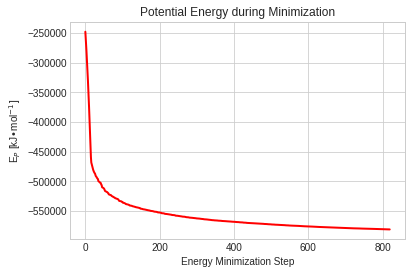

In [21]:
#@title ### 4. Plot the change in potential energy of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('em_potential.xvg')

plt.title('Potential Energy during Minimization')
plt.xlabel('Energy Minimization Step')
plt.ylabel(r'E$_P$ [kJ•mol$^{-1}]$')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

Next, we will **equilibrate the energy and density of our system at constant temperature and pressure** before the MD production runs.

First, we will equilibrate our system at a target temperature (in our case, 300K) using a thermal bath. The initial velocities for the atoms of our system at our target temperature are obtained through a Maxwell distribution.

In [22]:
#@title ### 5. Downloading an MD parameter file and running an NVT equilibration
%%time
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp

#Using grompp to prepare our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr -quiet

#Run our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm nvt -nb gpu -quiet

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:    59    Protein residues
There are: 10811      Water residues
There are:     2        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.097 nm
Set rlist, assuming 4x4 atom pair-list, to 1.225 nm, buffer size 0.025 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 44x44x44, spacing 0.158 0.158 0.158
This run will generate roughly 19 Mb of data


--2022-08-05 14:03:30--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2464 (2.4K) [text/plain]
Saving to: ‘nvt.mdp’

     0K ..                                                    100% 32.2M=0s

2022-08-05 14:03:30 (32.2 MB/s) - ‘nvt.mdp’ saved [2464/2464]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupino

CPU times: user 292 ms, sys: 80.4 ms, total: 373 ms
Wall time: 1min 12s


What we just did corresponds to a simulation setup in which the number of atoms, the volume and the temperature are kept constant: **NVT ensemble**. Thus, the temperature of the system should oscillate around the desired temperature (in our case, 300 K). We will confirm this condition below.

In [24]:
#@title ### 6. Extract the change in temperature during the NVT equilibration
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Temperature" > options
echo " " >> options

#Using energy to extract the temperature of the system during the NVT equil MD
gmx energy -f nvt.edr -o nvt_temp.xvg -xvg none -quiet < options


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.944       0.17    3.32583   0.899427  (K)


Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Vir-XX        
 21  Vir-XY          22  Vir-XZ          23  Vir-YX          24  Vir-YY        
 25  Vir-YZ          26  Vir-ZX          27  Vir-ZY          28  Vir-ZZ        
 29  Pres-XX         30  Pres-XY         31  Pres-XZ         32  Pres-YX       
 33  Pres-YY         34  Pres-YZ         35  Pres-ZX         36  Pres-ZY  

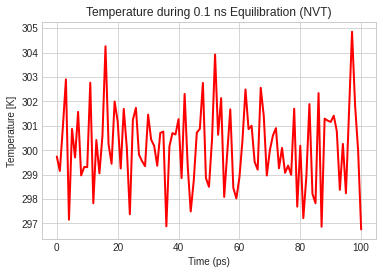

In [25]:
#@title ### 7. Plotting the change in temperature of the system during the NVT equilibration
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('nvt_temp.xvg')

plt.title('Temperature during 0.1 ns Equilibration (NVT)')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature [K]')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red') 
plt.show()

Lastly, we will equilibrate our system at **constant pressure**, which will maintain the density of our solvent constant so that it matches what we would expect for a protein in solution at atmospheric conditions. Thus, in this case we will be using an ensemble in which the number of atoms, the pressure and the temperature of the system remain constant: **the NPT ensemble**.

In [26]:
#@title ### 8. Downloading an MD parameter file and running an NPT equilibration 
%%time
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp

#Using grompp to prepare our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr -quiet

#Run our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm npt -nb gpu -quiet

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:    59    Protein residues
There are: 10811      Water residues
There are:     2        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.097 nm
Set rlist, assuming 4x4 atom pair-list, to 1.225 nm, buffer size 0.025 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 44x44x44, spacing 0.158 0.158 0.158
This run will generate roughly 19 Mb of data


--2022-08-05 14:10:02--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2687 (2.6K) [text/plain]
Saving to: ‘npt.mdp’

     0K ..                                                    100% 40.8M=0s

2022-08-05 14:10:03 (40.8 MB/s) - ‘npt.mdp’ saved [2687/2687]

Setting the LD random seed to 803569399
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Excluding 2 bonded neighbours molecule type 'SOL'
Excluding 1 bonded neighbours molecule type 'NA'

NOTE 1 [file topol.top, line 8693]:
  You are combining position restraints with

CPU times: user 285 ms, sys: 72.8 ms, total: 358 ms
Wall time: 1min 12s


7. Given that we are using an NPT ensemble to maintain our simulation at constant pressure and density, we should check if this is achieved.

In [28]:
#@title ### 9. Extract the change in pressure and density during the NPT equilibration 
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Pressure" > options
echo "Density" >> options
echo " "

#Using energy to extract the pressure and density of the system during the NPT equil MD
gmx energy -f npt.edr -o npt_press_dens.xvg -xvg none -quiet < options

 

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 2 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -2.02027          3    149.148    -10.654  (bar)
Density                     1007.42       0.32    2.95854  -0.385384  (kg/m^3)


                      :-) GROMACS - gmx energy, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

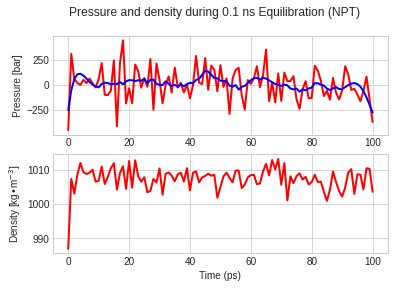

In [37]:
#@title ### 10. Plotting the change in pressure and density of the system during the NPT equilibration
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text files containing this information
data1 = np.loadtxt('npt_press_dens.xvg')
data2 = np.loadtxt('npt_press_dens.xvg')

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Pressure and density during 0.1 ns Equilibration (NPT)')

ax1.set(ylabel='Pressure [bar]')
#ax1.ylim(-250,250)

ax2.set(xlabel='Time (ps)', ylabel='Density [kg•m$^{-3}$]')
#ax2.ylim(1000,1020)

#Smoothing using Savitzky-Golay
from scipy.signal import savgol_filter
yhat = savgol_filter(data1[:,1], 21, 5)

#Plot raw data and spline interpolation
ax1.plot(data1[:,0], data1[:,1], linestyle='solid', linewidth='2', color='red')
ax1.plot(data1[:,0], yhat, linestyle='solid', linewidth='2', color='blue') 
ax2.plot(data2[:,0], data2[:,2], linestyle='solid', linewidth='2', color='red') 

plt.show()

### Part 4.B. Running and MD simulation

Now we are ready for running our MD simulations. Due to time constraints and the size of the system, we are only generating **0.1 ns of production runs**, whilst you will find that simulations in current articles often correspond to hundreds of ns.

In [38]:
#@title ### 1. Downloading an MD parameter file and runninng a production MD simulation
%%time
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md.mdp

#Using grompp to prepare our production MD
source /content/gromacs/bin/GMXRC
gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_1.tpr -quiet

#Run our production MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm md_1 -nb gpu -quiet

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:    59    Protein residues
There are: 10811      Water residues
There are:     2        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.298 nm, buffer size 0.098 nm
Set rlist, assuming 4x4 atom pair-list, to 1.225 nm, buffer size 0.025 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 44x44x44, spacing 0.158 0.158 0.158
This run will generate roughly 11 Mb of data


--2022-08-05 14:28:13--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2619 (2.6K) [text/plain]
Saving to: ‘md.mdp’

     0K ..                                                    100% 33.3M=0s

2022-08-05 14:28:13 (33.3 MB/s) - ‘md.mdp’ saved [2619/2619]

Setting the LD random seed to -1075843218
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Excluding 2 bonded neighbours molecule type 'SOL'
Excluding 1 bonded neighbours molecule type 'NA'
Number of degrees of freedom in T-Coupling group Protein is 2278.90
Number of degr

CPU times: user 274 ms, sys: 87 ms, total: 361 ms
Wall time: 1min 13s


To finalize, we will visualize our simulation. For this, we will use the `trjconv` module from GROMACS to remove the solvent from our system and convert our trajectory into a PDB file.

Given that our protein may have drifted from the center of the box and reached its edges, we will also take the opportunity to recenter the periodic box on our protein such that its atoms do not stretch through the edges of the periodic boundary conditions.

In [40]:
#@title ### 2. Removing the solvent from our MD simulation
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Protein" > options
echo "Protein" >> options
echo " "

#Using trjconv to extract only the protein atoms from the simulation trajectory
#and also recenter the protein if its atoms crossed the periodic boundaries
gmx trjconv -s md_1.tpr -f md_1.xtc -o md_traj.pdb -pbc mol -center -quiet < options

 
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


Will write pdb: Protein data bank file
Reading file md_1.tpr, VERSION 2020.6 (single precision)
Reading file md_1.tpr, VERSION 2020.6 (single precision)
Group     0 (         System) has 33350 elements
Group     1 (        Protein) has   915 elements
Group     2 (      Protein-H) has   449 elements
Group     3 (        C-alpha) has    59 elements
Group     4 (       Backbone) has   177 elements
Group     5 (      MainChain) has   237 elements
Group     6 (   MainChain+Cb) has   291 elements
Group     7 (    MainChain+H) has   296 elements
Group     8 (      SideChain) has   619 elements
Group     9 (    SideChain-H) has   212 elements
Group    10 (    Prot-Masses) has   915 elements
Group    11 (    non-Protein) has 32435 elements
Group    12 (          Water) has 32433 elements
Group    13 (            SOL) has 32433 elements
Group    14 (      non-Water) has   917 elements
Group    15 (            Ion) has     2 elements
Group    16 (             NA) has     2 elements
Group    17 ( 

In [41]:
#@markdown Now, you can download this new PDB file and load it onto [**NGLviewer**](http://nglviewer.org/ngl/) as a **trajectory** PDB file to visualize the protein motions explored within this short simulation time.
files.download(f"md_traj.pdb")
#@markdown This is the end of this hands-on tutorial. For more information about the analysis of your trajectories, please check the [GROMACS tutorials](http://www.mdtutorials.com/gmx/) developed by Justin Lemkul and our implementation of some of these analyses on Google Colab in our [Molecular Modeling and Simulation GitHub](https://github.com/pb3lab/ibm3202)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Emergency Backups 😱
If you run into any trouble during this tutorial, you can download any of these intermediate files for continuation: